#  Code for 2D staggered Lagrangian method in Cartersian coordinates

## Control equations

一般形式下，弹塑性流体控制方程为：

质量方程：
\begin{equation}
  \frac{dm}{dt}=0
  \end{equation}
动量方程：
\begin{equation}
  \frac{d\rho \mathbf{u}}{dt}= \nabla \cdot  \mathbf{\Pi} 
\end{equation}

能量方程：
\begin{equation}
 \rho \frac{de}{dt}= \mathbf{\sigma} \cdot \mathbf{\varepsilon}
\end{equation}

\section{二维控制方程}

运动方程：
\begin{equation}
  \frac{d(r,z)}{dt}=(u,v)
\end{equation}

质量守恒：
\begin{equation}\label{eq:38}
  \frac{dm}{dt}=0
\end{equation}

动量守恒方程：
\begin{equation}\label{eq:3}
  \begin{array}{l}
	\displaystyle \rho \frac{du}{dt}=\frac{\partial \sigma _{rr}}{\partial r}+ \frac{\partial s_{rz}}{\partial z}\\[0.3cm]
  \displaystyle \rho \frac{dv}{dt}=\frac{\partial \sigma _{zz}}{\partial z}+ \frac{\partial s_{rz}}{\partial r}\\
  \end{array}
  \end{equation}

能量守恒方程：
\begin{equation}
  \begin{array}{l}
	\displaystyle \rho \frac{de}{dt}=\sigma _{rr}\frac{\partial u}{\partial r}+\sigma_{zz}\frac{\partial v}{\partial z}+s_{rz}\left( \frac{\partial u}{\partial z}+\frac{\partial v}{\partial r}\right)\\[0.3cm]
	\displaystyle = -p\frac{dV}{dt}+ s_{rr}\frac{\partial u}{\partial r}+s_{zz}\frac{\partial v}{\partial z}+s_{rz}\left( \frac{\partial u}{\partial z}+\frac{\partial v}{\partial r}\right)\\
	\end{array}
	\end{equation}

本构方程：
\begin{equation}
  \begin{array}{l}
	\displaystyle \frac{ds_{rr}}{dt}=2\mu \left(\frac{\partial u}{\partial r}-\frac{1}{3}\nabla \cdot \vec{u} \right) +s_{rz}\left(\frac{\partial u}{\partial z}-\frac{\partial v}{\partial r}\right)\\[0.3cm]
	\displaystyle \frac{ds_{zz}}{dt}=2\mu \left(\frac{\partial v}{\partial z}-\frac{1}{3}\nabla \cdot \vec{u} \right) -s_{rz}\left(\frac{\partial u}{\partial z}-\frac{\partial v}{\partial r}\right)\\[0.3cm]
	\displaystyle \frac{ds_{rz}}{dt}=\mu \left(\frac{\partial u}{\partial z}+\frac{\partial v}{\partial r}\right) + \frac{s_{rr}-s_{zz}}{2}\left(\frac{\partial u}{\partial z}-\frac{\partial v}{\partial r}\right)\\
  \end{array}
  \end{equation}

Von Mises屈服条件：
\begin{equation}
  \frac{3}{2}(s_{rr}^2+s_{zz}^2+s_{\theta \theta}^2+2s_{xy}^2)\le (Y^0)^2
\end{equation}







$$ s_{\theta\theta} = - (s_{rr} +s_{zz}) $$

## Compatible Staggered Discretization

<img src="Grid.png" width = "800" height = "400" div align=center /> 

<img src="cellpoint.png" width = "800" height = "400" div align=center />

### Quatities:

On point: ($x_p$,$y_p$), ($u_p$,$v_p$)

Zonal:  $V_z$, $\rho_z$, $m_z$, $e_z$, $p_z$

By the relation 
$$\frac{dm_z}{dt} =0$$
we have 
$$\rho_z(t) = m_z/V_z(t)$$

Also 
$$d(x_p)/dt = u_p, \quad d(y_p)/dt = v_p$$

In [1]:
struct Const
    Y0 ::Float64 #Yielding strength
    ρ0 ::Float64 
    Γ0 ::Float64
    μ  ::Float64
    a0 ::Float64
    s0 ::Float64
end


In [2]:
mutable struct Var
    r::Array{Float64,1}
    z::Array{Float64,1}
    u::Array{Float64,1}
    v::Array{Float64,1}
    ρ::Array{Float64,1}
    p::Array{Float64,1}
    s::Array{Float64,2} # σ[1] = σrr σ[2] = σzz σ[3] = σrz
end    

In [3]:
struct prb
    tt::Float64
    sf::Float64
end

### Point mass 

Point mass $m_p$ is used to solve point momentum $\mu_p = m_p \bf{u}_p$ and kinetic energy $K_p = m_p \frac{\bf{u}_p^2}{2}$

<img src="Ins.jpg" width = "200" height = "400" div align=center /> 

$$m_p = \sum_{z\in Z(p)} A_z^p \rho^p_z$$

$$\rho_z(t) = m_z/V_z(t)$$

In [4]:
function MassAndDens(mz::Array{Float64,1},x::Array{Float64,1},y::Array{Float64,1})
    
    Ic, = size(mz)
    Ip, = size(Tc)
    Asbz = zeros(Float64,4)
    ρ = zeros(Float64,Ic)
    mp = zeros(Float64,Ip)
    xz = zeros(Float64,4)
    yz = zeros(Float64,4)
    for i in 1:Ic
        xz[1:4] = x[Tp[i,1:4]]
        yz[1:4] = y[Tp[i,1:4]]
        Asbz = A_z(xz,yz)
        Az = sum(Asbz)
        ρ[i] = mz[i]/Az
        
        for j = 1:4
            ip = Tp[i,j]
            mp[ip] = mp[ip] + Asbz[j]*ρ[i]
        end
    end
   # @show mp
    return ρ,mp   
end

MassAndDens (generic function with 1 method)


$$ A_z^1 = \frac{5A_{41}+5A_{12}+A_{23}+A_{34}}{12}$$
$$ A_z^2 = \frac{A_{41}+5A_{12}+5A_{23}+A_{34}}{12}$$
$$ A_z^3 = \frac{A_{41}+A_{12}+5A_{23}+5A_{34}}{12}$$
$$ A_z^4 = \frac{5A_{41}+A_{12}+A_{23}+5A_{34}}{12}$$

In [5]:
function A_z(xz,yz) 
    A =zeros(Float64,4)
    xc= sum(xz[i] for i in 1:4)/4
    yc= sum(yz[i] for i in 1:4)/4
    
    A41 = Area3(xz[4],xz[1],xc,yz[4],yz[1],yc)
    A12 = Area3(xz[1],xz[2],xc,yz[1],yz[2],yc)
    A23 = Area3(xz[2],xz[3],xc,yz[2],yz[3],yc)
    A34 = Area3(xz[3],xz[4],xc,yz[3],yz[4],yc)

    A[1] = (5A41+5A12+A23+A34)/12
    A[2] = (A41+5A12+5A23+A34)/12
    A[3] = (A41+A12+5A23+5A34)/12
    A[4] = (5A41+A12+A23+5A34)/12
    
#    A[1] = (A41+A12+A23+A34)/4
#    A[2] = (A41+A12+A23+A34)/4
#    A[3] = (A41+A12+A23+A34)/4
#    A[4] = (A41+A12+A23+A34)/4
    
    return A
end

A_z (generic function with 1 method)

<img src="n12.png" width = "300" height = "300" div align=center />

$$\overrightarrow{n}_{12} = \frac{1}{L_{12}}(y_2- y_1, x_1-x_2)  $$

$$\overrightarrow{\tau}_{12} = \frac{1}{L_{12}}(x_2- x_1, y_2-y_1)  $$

$$ \mathbf{F_1}  = \frac{1}{2}  \left[ -\sigma_{rr}(z_2-z_4)+ s_{rz}(r_2 -r_4), \sigma_{zz}(r_2-r_4) +s_{rz}(z_4 -z_2) , \right] $$ 

In [6]:
function force_zone(x,y,u,v,ρ,p,σ) #(r,z)
   
    Fx = zeros(Float64,4)
    Fy = zeros(Float64,4)
    
    
    Fx[1] = 0.5(σ[1]*(y[4] - y[2]) + σ[3]*(x[2] - x[4]))
    Fy[1] = 0.5(σ[3]*(y[4] - y[2]) + σ[2]*(x[2] - x[4]))
    
    Fx[2] = 0.5(σ[1]*(y[1] - y[3]) + σ[3]*(x[3] - x[1]))
    Fy[2] = 0.5(σ[3]*(y[1] - y[3]) + σ[2]*(x[3] - x[1]))
    
    Fx[3] = 0.5(σ[1]*(y[2] - y[4]) + σ[3]*(x[4] - x[2]))
    Fy[3] = 0.5(σ[3]*(y[2] - y[4]) + σ[2]*(x[4] - x[2]))
    
    Fx[4] = 0.5(σ[1]*(y[3] - y[1]) + σ[3]*(x[1] - x[3]))
    Fy[4] = 0.5(σ[3]*(y[3] - y[1]) + σ[2]*(x[1] - x[3]))
      
    ex,ey = hourglass_viscosity(x, y, u, v, ρ, p,σ) 

    Fx = Fx .+ ex
    Fy = Fy .+ ey
    
    return Fx,Fy
end           

force_zone (generic function with 1 method)

\begin{equation}
  \begin{aligned}
	&\displaystyle \rho \frac{de}{dt}= \mathbf{\sigma} \cdot \mathbf{\varepsilon}\\ 
	&=
	\sigma _{rr}\frac{\partial u}{\partial r}+\sigma_{zz}\frac{\partial v}{\partial z}+\sigma_{rz}\left( \frac{\partial u}{\partial z}+\frac{\partial v}{\partial r}\right)
	\end{aligned}
	\end{equation}
    
\begin{equation}
  \begin{aligned}
	&\displaystyle M \frac{de}{dt}=  
\int_{\Omega} \sigma _{rr}\frac{\partial u}{\partial r}+\sigma_{zz}\frac{\partial v}{\partial z}+\sigma_{rz}\left( \frac{\partial u}{\partial z}+\frac{\partial v}{\partial r}\right)d\Omega
	\end{aligned}
	\end{equation}


\begin{equation}
  \begin{aligned}
\int_{\Omega}  \frac{\partial u}{\partial r} d\Omega&=  -\oint_{\partial \omega}u dz\\
  &= \frac{1}{2} \left((u_1-u_3)(z_2-z_4)+(u_2-u_4)(z_3-z_1)\right)
  \end{aligned}
\end{equation}

\begin{equation}
  \begin{aligned}
\int_{\Omega}  \frac{\partial u}{\partial z} d\Omega&= \oint_{\partial \omega}u dy\\
  &= -\frac{1}{2} \left((u_1-u_3)(r_2-r_4)+(u_2-u_4)(r_3-r_1)\right)
  \end{aligned}
\end{equation}

$$ \frac{\partial u}{\partial x}  \approx \frac{1}{2A}((u_1-u_3)(y_2-y_4)+(u_2-u_4)(-y_1+y_3))$$ 

$$ \frac{\partial v}{\partial y}  \approx -\frac{1}{2A}((v_1-v_3)(x_2-x_4)+(v_2-v_4)(-x_1+x_3))$$ 

对于节点
$$ \rho \frac{d \mathbf{u}}{dt} = - \nabla p$$

$$m_p \frac{d\bf{u}_p}{dt} = \sum_{p\in P(z)} \bf{F}_z^p$$

$$F_z^1 = \mathbf{F}_1 + c\mathbf{e}_1$$

本构方程：
\begin{equation}
  \begin{array}{l}
	\displaystyle \frac{ds_{rr}}{dt}=2\mu \left(\frac{\partial u}{\partial r}-\frac{1}{3}\nabla \cdot \vec{u} \right) +s_{rz}\left(\frac{\partial u}{\partial z}-\frac{\partial v}{\partial r}\right)\\[0.3cm]
	\displaystyle \frac{ds_{zz}}{dt}=2\mu \left(\frac{\partial v}{\partial z}-\frac{1}{3}\nabla \cdot \vec{u} \right) -s_{rz}\left(\frac{\partial u}{\partial z}-\frac{\partial v}{\partial r}\right)\\[0.3cm]
	\displaystyle \frac{ds_{rz}}{dt}=\mu \left(\frac{\partial u}{\partial z}+\frac{\partial v}{\partial r}\right) - \frac{s_{rr}-s_{zz}}{2}\left(\frac{\partial u}{\partial z}-\frac{\partial v}{\partial r}\right)\\
  \end{array}
  \end{equation}

Von Mises屈服条件：
\begin{equation}
  \frac{3}{2}(s_{rr}^2+s_{zz}^2+s_{\theta \theta}^2+2s_{xy}^2)\le (Y^0)^2
\end{equation}


In [7]:
function rhs(var::Var)
    μ = con1.μ
    r,z,u,v,ρ,p,s = var.r,var.z,var.u,var.v,var.ρ,var.p,var.s
    
    Ic, = size(Tp)
    Ip, = size(Tc)
    rhsu = zeros(Float64,Ip)
    rhsv = zeros(Float64,Ip) 
    rhse = zeros(Float64,Ic)
    rhss = zeros(Float64,Ic,3)
    σ = zeros(Float64,Ic,3)
  
    σ[:,1] = s[:,1] - p[:]
    σ[:,2] = s[:,2] - p[:]
    σ[:,3] = s[:,3] 
    
    rcell = zeros(Float64,4)
    zcell = zeros(Float64,4)
    ucell = zeros(Float64,4)
    vcell = zeros(Float64,4)
    
    for i in 1:Ic
        for j =1:4
            rcell[j] = r[Tp[i,j]]
            zcell[j] = z[Tp[i,j]]
            ucell[j] = u[Tp[i,j]]
            vcell[j] = v[Tp[i,j]]
        end
        Az = sum(A_z(rcell,zcell))
        Fx,Fy = force_zone(rcell,zcell,ucell,vcell,ρ[i],p[i],σ[i,1:3])  
        ∂u_∂r,∂u_∂z = ∂uv(rcell,zcell, ucell)
        ∂v_∂r,∂v_∂z = ∂uv(rcell,zcell, vcell)
        rhse[i] = σ[i,1]*∂u_∂r + σ[i,2]*∂v_∂z+σ[i,3]*(∂u_∂z + ∂v_∂r)
        for j = 1:4
            ip = Tp[i,j]
            rhsu[ip] +=  Fx[j]
            rhsv[ip] +=  Fy[j]
        end  
        ∇u = ∂u_∂r + ∂v_∂z
    
        rhss[i,1] =  (2μ*(2/3*∂u_∂r - 1/3*∂v_∂z) + σ[i,3]*(∂u_∂z - ∂v_∂r)) ./Az
        rhss[i,2] =  (2μ*(2/3*∂v_∂z - 1/3*∂u_∂r) - σ[i,3]*(∂u_∂z - ∂v_∂r)) ./Az
        rhss[i,3] =   (μ*(∂u_∂z+∂v_∂r)  -   (σ[i,1] - σ[i,2])*(∂u_∂z - ∂v_∂r)) ./Az      
    end

    return rhse, rhsu,rhsv,rhss

end     

rhs (generic function with 1 method)

In [8]:
function output(f)
    io = open("data2.dat", "w+")
     writedlm(io,f,"  ") 
    close(io)
end

output (generic function with 1 method)

$$ \mathbf{S} = \mathbf{S} \times \text{min} \left(1,Y_0/\sqrt{\frac{3}{2}\mathbf{S}:\mathbf{S}}\right)$$

In [9]:
function yield_s!(s,con)
    Y0 = con.Y0
    I, = size(s)
    for i in 1:I
         sums = s[i,1]^2 +s[i,2]^2 +2*s[i,3]^2 +(s[i,1]+s[i,2])^2
        for j = 1:3
       
        s[i,j] = s[i,j] * min(1,Y0/√(3/2*sums))
            end 
    end
    return s
end

yield_s! (generic function with 1 method)

In [10]:
function predictor_corrector2nd(dt,var::Var,mz)
    r,z,u,v,ρ,p,s = var.r,var.z,var.u,var.v,var.ρ,var.p,var.s
    
    Ip, = size(u)
    Ic, = size(p)
    
    ρ,mp = MassAndDens(mz,r,z)
    e = p_to_e(ρ, p,con1)    
    p = artificial_viscosity!(r,z,u,v,ρ,p)
    ρ,p,s = bound_ghost_cell!(ρ,p,s)
    var = Var(r, z, u, v, ρ, p, s)
    
    rhse, rhsu,rhsv,rhss = rhs(var)
    rhsu,rhsv = bound_force(rhsu,rhsv,var)
    
    s = yield_s!(s,con1)
    r₀ =  r + dt*u
    z₀  = z + dt*v
    u₀  = u + dt*(rhsu ./ mp)
    v₀  = v + dt*(rhsv ./ mp)
    e₀  = e + dt*(rhse ./ mz) 
    s₀  = s + dt*rhss
  #  @show rhsu
    s₀ = yield_s!(s₀,con1)
    r₀,z₀,u₀,v₀ = bound_ghost_coordinate!(r₀,z₀,u₀,v₀)
    ρ,mp = MassAndDens(mz,r₀,z₀)
    p = e_to_p(ρ,e₀,con1)
    p = artificial_viscosity!(r₀,z₀,u₀,v₀,ρ,p) 
    ρ,p,s₀ = bound_ghost_cell!(ρ,p,s₀)
    var = Var(r₀, z₀, u₀, v₀, ρ, p, s₀)
   
    rhse₀,rhsu₀,rhsv₀,rhss₀ = rhs(var)
    rhsu₀,rhsv₀ = bound_force(rhsu₀,rhsv₀,var)
  #  @show s[:,1]
    r +=  0.5dt*(u + u₀)
    z +=  0.5dt*(v + v₀)
    u +=  0.5dt*(rhsu + rhsu₀) ./ mp
    v +=  0.5dt*(rhsv + rhsv₀) ./ mp
    e +=  0.5dt*(rhse + rhse₀) ./ mz
    s  += 0.5dt*(rhss + rhss₀)
    s = yield_s!(s,con1)
    r,z,u,v = bound_ghost_coordinate!(r,z,u,v)
    ρ,mp = MassAndDens(mz,r,z)
    p = e_to_p(ρ,e,con1)
    ρ,p,s = bound_ghost_cell!(ρ,p,s)
    var = Var(r,z,u,v,ρ,p,s)
   
    return var
end

predictor_corrector2nd (generic function with 1 method)

In [11]:
function fη(ρ,c::Const)
    η = ρ/c.ρ0
    fη=(η .-1.0) .* (η .-c.Γ0*(η .-1.0)/2.0) ./ (η .-c.s0*(η .-1)) .^2
end

function fηη(ρ,c::Const)
    η = ρ/c.ρ0
    fηη=(η .+(c.s0-c.Γ0) .* (η .-1)) ./(η .-c.s0*(η .- 1)) .^3
end

fηη (generic function with 1 method)

In [12]:
function euler1st(dt,var::Var,mz)
    r,z,u,v,ρ,p,s = var.r,var.z,var.u,var.v,var.ρ,var.p,var.s
    
    Ip, = size(u)
    Ic, = size(p)
    
    ρ,mp = MassAndDens(mz,r,z)
    e = p_to_e(ρ, p,con1)    
    p = artificial_viscosity!(r,z,u,v,ρ,p)
    ρ,p,s = bound_ghost_cell!(ρ,p,s)
    var = Var(r, z, u, v, ρ, p, s)
    
    rhse, rhsu,rhsv,rhss = rhs(var)
    rhsu,rhsv = bound_force(rhsu,rhsv,var)
    
 #   @show rhsv
    s = yield_s!(s,con1)
    r =  r + dt*u
    z = z + dt*v
    u  = u + dt*(rhsu ./ mp)
    v  = v + dt*(rhsv ./ mp)
    e  = e + dt*(rhse ./ mz) 
    s  = s + dt*rhss
  #  @show rhsu
    s = yield_s!(s,con1)
    r,z,u,v = bound_ghost_coordinate!(r,z,u,v)
    ρ,mp = MassAndDens(mz,r,z)
    p = e_to_p(ρ,e,con1)
    ρ,p,s = bound_ghost_cell!(ρ,p,s)
    var = Var(r,z,u,v,ρ,p,s)
   
    return var
end

euler1st (generic function with 1 method)

### Boundary force

If one edge of a cell is a free boundary, then $f$ on the points is zero. As we have add it in RHs(), we need to remove it by resolve it again. Different from RHs(), at every point of a cell the force is composited by two parts on different edges. This is distinguished by $k$ when $k = 1$ the boundary is on y direction, forces on 12 and 34 boundary must be subtracted. When $ k =2$ the boundary is on x direction, subtract forces on 41, 23. 

In [13]:
function bound_force(rhsu,rhsv,var)
    Ip, = size(Tc)
    Ib, = size(Tb)
   
    r,z,u,v,ρ,p,s = var.r,var.z,var.u,var.v,var.ρ,var.p,var.s
    rcell = zeros(Float64,4)
    zcell = zeros(Float64,4)
    ucell = zeros(Float64,4)
    vcell = zeros(Float64,4)
    ip1 = zeros(Int,4)
    σ = zeros(Float64,3)
    for i in 1:Ib
        if Tb[i,4] == 1 || Tb[i,4] == 3
            ic = Tb[i,1]        
            rcell[1:4] = r[Tp[ic,1:4]]
            zcell[1:4] = z[Tp[ic,1:4]]
            ucell[1:4] = u[Tp[ic,1:4]]
            vcell[1:4] = v[Tp[ic,1:4]]

            σ[1] = s[ic,1] - p[ic]
            σ[2] = s[ic,2] - p[ic]
            σ[3] = s[ic,3]

            ex,ey = hourglass_viscosity(rcell, zcell, ucell, vcell, ρ[ic]
                                        , p[ic],s[ic,:])
            i₁ = Tb[i,3]
            i₂ = i₁+1
            if i₁ == 4
                i₂ = 1
            end
            nx = zcell[i₂] -zcell[i₁]
            ny = rcell[i₁] -rcell[i₂]
            p0 = 1e-10
            for j in (i₁,i₂)

                ip = Tp[ic,j]
                    Fx = -σ[1]*nx/2 -σ[3]*ny/2+ex[j] #*nx^2/(nx^2+ny^2)  #+ex[j] 
                    Fy = -σ[3]*nx/2 -σ[2]*ny/2+ey[j] #*ny^2/(nx^2+ny^2)
                    Fx1 = (Fx*nx+Fy*ny)*nx/(nx^2+ny^2)
                    Fy1 = (Fx*nx+Fy*ny)*ny/(nx^2+ny^2)
                    Fx = Fx- Fx1
                    Fy = Fy - Fy1
                    Fx1 =  p0*nx/2 #+ex[j]*nx^2/(nx^2+ny^2) 
                    Fy1 =  p0*ny/2 #+ey[j]*ny^2/(nx^2+ny^2)

                #    rhsu[ip] +=  -Fx1 # -Fx1
                #    rhsv[ip] +=  -Fy1 #-Fy1

                if Tb[i,4] == 3 # boundary
                    uL = 2e-3
                    u[ip] = uL #*nx/(nx^2 +ny^2)
                end  
            end
        end
    end 

    return rhsu, rhsv
end  

bound_force (generic function with 1 method)

<img src="bound_corresponding.png" width = "400" height = "800" div align=center /> 

$$ Ig_1 = Tb[i,3] $$
$$Ib_1 = Ig_1 -1$$

In [14]:
function bound_ghost_coordinate!(r,z,u,v)
    Ip, = size(Tc)
    Ic, = size(Tp)
    Ib, = size(Tb)
   # r,z,u,v,ρ,p,s = var.r,var.z,var.u,var.v,var.ρ,var.p,var.s
   
    rt= copy(r)
    zt= copy(z)
   # output(r)
    for i in 1:Ib
        if Tb[i,4] == 2
            ic = Tb[i,1]
            ic2= Tb[i,2]
            ig₁ = Tb[i,3]
            
           
            ig₁ == 4 ? ig₂ = 1 : ig₂ = ig₁+1
            ig₂ == 4 ? ig₃ = 1 : ig₃ = ig₂+1
            ig₃ == 4 ? ig₄ = 1 : ig₄ = ig₃+1

            ig₁ == 1 ? ib₁ = 4 : ib₁ = ig₁-1
            ib₁ == 1 ? ib₂ = 4 : ib₂ = ib₁-1
            ib₂ == 1 ? ib₃ = 4 : ib₃ = ib₂-1
            ib₃ == 1 ? ib₄ = 4 : ib₄ = ib₃-1

                r1 =    rt[Tp[ic2,ib₁]]
                r2 =    rt[Tp[ic2,ib₂]]
                z1 =    zt[Tp[ic2,ib₁]]
                z2 =    zt[Tp[ic2,ib₂]]

                r3=     rt[Tp[ic2,ib₃]]
                z3=     zt[Tp[ic2,ib₃]]
                r4=     rt[Tp[ic2,ib₄]]
                z4=     zt[Tp[ic2,ib₄]]
                
                nx = zt[Tp[ic2,ib₁]] -zt[Tp[ic2,ib₂]]
                ny = rt[Tp[ic2,ib₂]] -rt[Tp[ic2,ib₁]]
                for j in (ib₁,ib₂)
                    ip = Tp[ic2,j]
                    u[ip] = u[ip]*ny^2/(nx^2 +ny^2)
                    v[ip] = v[ip]*nx^2/(nx^2 +ny^2)
                end

                r[Tp[ic,ig₃]],z[Tp[ic,ig₃]] = reflect(r1,z1,r2,z2,r3,z3)
                r[Tp[ic,ig₄]],z[Tp[ic,ig₄]] = reflect(r1,z1,r2,z2,r4,z4)
                u[Tp[ic,ig₃]],v[Tp[ic,ig₃]] = u[Tp[ic2,ib₃]],v[Tp[ic2,ib₃]]
                u[Tp[ic,ig₄]],v[Tp[ic,ig₄]] = u[Tp[ic2,ib₄]],v[Tp[ic2,ib₄]]
            
       
          end 
    end
    return r,z,u,v
end  

bound_ghost_coordinate! (generic function with 1 method)

In [15]:
function bound_ghost_cell!(ρ,p,s)
    Ip, = size(Tc)
    Ic, = size(Tp)
    Ib, = size(Tb)    
    for i in 1:Ib
        if Tb[i,4] == 2
            ic = Tb[i,1]
            ic2= Tb[i,2]
            ρ[ic] = ρ[ic2]
            p[ic] = p[ic2]
            s[ic,1:2] = s[ic2,1:2]
            s[ic,3] = -s[ic2,3]
          end 
    end
    return ρ,p,s
end  

bound_ghost_cell! (generic function with 1 method)

In [16]:
exp1[r4]

UndefVarError: UndefVarError: exp1 not defined

## Ghost cell coordinate of a reflect boundary

<img src="reflect.png" width = "200" height = "400" div align=center /> 

$$ k_1 k_2 = -1$$
$$ d_3 = -d_4 $$

$$(z_2-z_1)(z_3-z_4)+(r_3-r_4)(r_2-r_1) = 0$$
$$(z_2-z_1)(r_3-r_1)-(z_3-z_1)(r_2-r_1) = -(z_2-z_1)(r_4-r_1)+(z_4-z_1)(r_2-r_1)$$

In [17]:
using SymPy
@vars z1 z2 z3 z4 r1 r2 r3 r4
exp1 = solve([(z2-z1)*(z3-z4)+(r2-r1)*(r3-r4),(z2-z1)*(r3-r1)-(z3-z1)*(r2-r1)+(z2-z1)*(r4-r1)-(z4-z1)*(r2-r1)],[r4,z4])
@show exp1[r4],exp1[z4]

┌ Info: Recompiling stale cache file /home/bfly/.juliapro/JuliaPro_v1.1.1.1/compiled/v1.1/SymPy/KzewI.ji for SymPy [24249f21-da20-56a4-8eb1-6a02cf4ae2e6]
└ @ Base loading.jl:1184


(exp1[r4], exp1[z4]) = (((r1 - r2)*(r1*r3 - r2*r3 + z1*z3 - z2*z3) - (z1 - z2)*(2*r1*z2 - r1*z3 - 2*r2*z1 + r2*z3 + r3*z1 - r3*z2))/((r1 - r2)^2 + (z1 - z2)^2), ((r1 - r2)*(2*r1*z2 - r1*z3 - 2*r2*z1 + r2*z3 + r3*z1 - r3*z2) + (z1 - z2)*(r1*r3 - r2*r3 + z1*z3 - z2*z3))/((r1 - r2)^2 + (z1 - z2)^2))


(((r1 - r2)*(r1*r3 - r2*r3 + z1*z3 - z2*z3) - (z1 - z2)*(2*r1*z2 - r1*z3 - 2*r2*z1 + r2*z3 + r3*z1 - r3*z2))/((r1 - r2)^2 + (z1 - z2)^2), ((r1 - r2)*(2*r1*z2 - r1*z3 - 2*r2*z1 + r2*z3 + r3*z1 - r3*z2) + (z1 - z2)*(r1*r3 - r2*r3 + z1*z3 - z2*z3))/((r1 - r2)^2 + (z1 - z2)^2))

In [18]:
function reflect(r1,z1,r2,z2,r3,z3)
    tmp1=(r1*r3-r2*r3+z1*z3-z2*z3) 
    tmp2 = (2r1*z2-r1*z3-2r2*z1+r2*z3+r3*z1-r3*z2)
    tmp3 = ((r1-r2)^2+(z1-z2)^2)
    
    r4 = ((r1-r2)*tmp1 - (z1-z2)*tmp2)/tmp3
    z4 = ((r1-r2)*tmp2 + (z1-z2)*tmp1)/tmp3
    
    return r4,z4
end

reflect (generic function with 1 method)

In [19]:
reflect(1,1,1,0,0.9,0)

(1.1, 0.0)

### EOS 
$$ e = \frac{p}{(\gamma-1)\rho}$$

In [20]:
function p_to_e(ρ,p,con)
    c=con
    ei = (p .- c.ρ0*c.a0^2*fη(ρ,c))/(c.ρ0*c.Γ0)
    return ei
end
function e_to_p(ρ,ei,con::Const)
    c=con
    p = c.ρ0*c.Γ0*ei .+ c.ρ0*c.a0^2*fη(ρ,c)
    return p
end

e_to_p (generic function with 1 method)

In [21]:
function CFL(SF,var)
    r,z,u,v,ρ,p,s = var.r,var.z,var.u,var.v,var.ρ,var.p,var.s
    Ic, = size(ρ)
    cflmin = 1.e9
      cfl = 0 
    for i in 1:Ic
        cfl =0
        u2max = 0
        u2=0.0
        for j = 1:4
            ip = Tp[i,j]
            u2 = u[ip]^2+v[ip]^2
            if u2 > u2max ; u2max = u2; end
        end
        
        dlmin = (r[Tp[i,4]] - r[Tp[i,1]])^2+(z[Tp[i,4]]-z[Tp[i,1]])^2
       
        for j=1:3
            dl= (r[Tp[i,j+1]] - r[Tp[i,j]])^2+(z[Tp[i,j+1]]-z[Tp[i,j]])^2
            if dl < dlmin; dlmin=dl; end
        end
        c = sound([ρ[i],u[i],p[i],min(s[i,1],s[i,2])],con1)
        cfl = √(dlmin)/(√(u2max)+c)
        if cfl < cflmin; cflmin = cfl; end
    end
 #   @show cflmin
    dt = cflmin*SF
    return dt
end 
        

CFL (generic function with 1 method)

In [22]:
function sound(uo::Array{Float64,1},con::Const,EoP::Int=1)
    a0,ρ0,Γ0,Y0,μ  = con.a0,con.ρ0,con.Γ0,con.Y0,con.μ
    ρ,uu,p,sxx   = uo[1:4]
    a2  = a0^2*fηη(ρ,con)+p/ρ^2*ρ0*Γ0
    if EoP == 2
        c=sqrt(a2-ρ0/ρ^2*Γ0*sxx)
        return c
    else
       #  @show a2,ρ0/ρ^2,4.0/3*μ/ρ
        c=sqrt(a2-ρ0/ρ^2*Γ0*sxx+4.0/3*μ/ρ)
       
        return c
    end
end

sound (generic function with 2 methods)

In [23]:
function TimeSolve(var,mz)
    tt= problem.tt
    sf =problem.sf
    t= 0.0
    t₁ = tt/100
    t₂ = t₁
    kinetic_init,energy_init = total_kinetic(var,mz)
    kinetic = kinetic_init
   # while kinetic > 1e-4*kinetic_init && t<tt
    while t<tt
    
#for i in 1:50
        dt=CFL(sf,var)
   #     @show dt
        if t+dt>tt
           dt = tt-t
        end
        
        var = predictor_corrector2nd(dt,var,mz)
       # var = euler1st(dt,var,mz)
   #     kinetic,energy = total_kinetic(var,mz)
         t += dt
        if t > t₁
            println(t)
            t₁ += t₂
     #       @show kinetic/kinetic_init,(energy+kinetic)/(kinetic_init+energy_init)
        end
        
    end
    return var
end

TimeSolve (generic function with 1 method)

In [24]:
function total_kinetic(var,mz)
    r,z,u,v,ρ,p = var.r,var.z,var.u,var.v,var.ρ,var.p
    Ip, = size(Tc)
    Ic, = size(Tp)
    Ib, = size(Tb)
    k = zeros(Float64,Ip)
    
    kinetic = 0
    energy = 0
     ρ1,mp = MassAndDens(mz, r, z)
    
    for i in 1:Ip
        k[i]= mp[i]*0.5*(u[i]^2+v[i]^2)
    end
    
    
    for i in 1:Ic
        energy += mz[i]*p_to_e(ρ[i], p[i], con1)
    end
    
    for i in 1:Ib
        if Tb[i,4] == 2
            ic= Tb[i,1]
            energy -= mz[ic]*p_to_e(ρ[ic], p[ic], con1)
            
            ig₁ = Tb[i,3]
            ig₁ == 4 ? ig₂ = 1 : ig₂ = ig₁+1
            k[Tp[ic,ig₁]] = 0
            k[Tp[ic,ig₂]] = 0
            end
    end
    kinetic = sum(k)
    return kinetic,energy
end


total_kinetic (generic function with 1 method)

## Artificial Viscosity 

Use the strain rate to construct the artificial viscosity 
$$\frac{ds}{dt} = \frac{\partial u}{\partial x}  + \frac{\partial v}{\partial y} $$


Then the artificial viscosity can be written as
$$ q_w = \left\{ \begin{align}
\alpha L \rho \left( \frac{ds}{dt} \right)^2 +  \beta L^2 \rho c \left|\frac{ds}{dt}\right|, \quad \text{if}  \quad \frac{ds}{dt}< 0,\\
0, \quad \text{if} \quad \frac{ds}{dt}\ge 0. \\
\end{align}
\right.
$$
where $\alpha = 0.6$, $\beta = 2.0 $ and $c$ is the sonic speed.

$L$ is the reference length, and constructed as
$$L = A/L_{\text{max}} $$

$$L_{\text{max}} = \text{max}(L_{13},L_{24})$$


In [25]:
function artificial_viscosity_c!(x,y,u,v,ρ,p)
    xc = sum(x[i] for i in 1:4)/4
    yc = sum(y[i] for i in 1:4)/4
    
    ∂u_∂x,tmp = ∂uv(x,y,u)
    tmp,∂v_∂y = ∂uv(x,y,v)
    c = sound([ρ,0.0,p,0.0],con1)
    Lmax = max(√((x[3] - x[1])^2+(y[3] - y[1])^2) ,√((x[2] - x[4])^2+(y[2] - y[4])^2) )  
    A = area_quadrangle(x, y)
    L = A/Lmax 

    if ∂u_∂x + ∂v_∂y> 0
        q = 0
    else
        q = 0.6ρ*L*c*(abs(∂u_∂x+∂v_∂y))/A +2.0L^2*ρ*((∂u_∂x+∂v_∂y)^2)/A^2 
    end
    return p+q
end

artificial_viscosity_c! (generic function with 1 method)

$$b_2 \rho Lc \frac{\partial u}{\partial x} - b_{12}\rho L^2 \left(\frac{\partial u}{\partial x}\right)^2$$

In [26]:
function artificial_viscosity!(r,z,u,v,ρ,p)
    I, = size(Tp)
    rcell = zeros(Float64,4)
    zcell = zeros(Float64,4)
    ucell = zeros(Float64,4)
    vcell = zeros(Float64,4)
   
    for i in 1:I
        for j in 1:4
            ip = Tp[i,j]
            rcell[j] = r[ip]
            zcell[j] = z[ip]
            ucell[j] = u[ip]
            vcell[j] = v[ip]
        end
        p[i] = artificial_viscosity_c!(rcell,zcell,ucell,vcell,ρ[i],p[i])
    end
    
        return p
        
    end       

artificial_viscosity! (generic function with 1 method)

In [27]:
function l_viscosity(x,y,α)
    xc = sum(x)/4; yc = sum(y)/4
    d = zeros(Float64,4)
    for i in 1:4
    d[i] = distance(x[i],y[i],xc,yc,α)
    end
    A = A_z(x, y)
    L = 2sum(A)/sum(d)
    return L
end

l_viscosity (generic function with 1 method)

#### distance from  Point to line 
Line: $$ (xc -cos \alpha )(x-xc) = (yc-sin \alpha)(y-yc)$$
point: $x,y$

In [28]:
function distance(x,y,xc,yc,α)
    d = abs((xc - cosd(α)) * (x .-xc)- (yc-sind(α))*(y .- yc))/√((xc-cosd(α))^2+(yc-sind(α))^2)
    return d
end

distance (generic function with 1 method)

### 沙漏粘性 Hourglass

$$ \text{hg}_x = u_1 -u_2 + u_3 - u_4$$ 
$$ \text{hg}_x = v_1 -v_2 + v_3 - v_4$$ 

$$ e_{1x} = -\frac{1}{4}q\rho c\sqrt{A}\text{hg}_x $$
$$ e_{1y} = -\frac{1}{4}q\rho c\sqrt{A}\text{hg}_y $$

$$ e_{2x} = \frac{1}{4}q\rho c\sqrt{A}\text{hg}_x $$
$$ e_{2y} = \frac{1}{4}q\rho c\sqrt{A}\text{hg}_y $$

$$ e_{3x} = -\frac{1}{4}q\rho c\sqrt{A}\text{hg}_x $$
$$ e_{3y} = -\frac{1}{4}q\rho c\sqrt{A}\text{hg}_y $$

$$ e_{4x} = \frac{1}{4}q\rho c\sqrt{A}\text{hg}_x $$
$$ e_{4y} = \frac{1}{4}q\rho c\sqrt{A}\text{hg}_y $$

In [29]:
function hourglass_viscosity(x,y,u,v,ρ,p,s)
    hgx = u[1] - u[2] + u[3] -u[4]
    hgy = v[1] - v[2] + v[3] -v[4]
    
    ex =zeros(Float64,4)
    ey =zeros(Float64,4)
    A = area_quadrangle(x,y)
    c = sound([ρ,0.0,p,min(s[1],s[2])], con1)
 #   @show c
    q = 0.1 # coefficient of hourglass viscosity 0.01 - 0.5 ?
    ex[1] = -0.25q*ρ*c*√(A)*hgx
    ey[1] = -0.25q*ρ*c*√(A)*hgy
    
    ex[2] = -ex[1]
    ey[2] = -ey[1]
    
    ex[3] = ex[1]
    ey[3] = ey[1]
    
    ex[4] = ex[2]
    ey[4] = ey[2]
    
  #ex .= 0
 # ey .= 0
 #   @show ex,ey
    return ex, ey
end

hourglass_viscosity (generic function with 1 method)

In [30]:
function area_quadrangle(x::Array{Float64,1},y::Array{Float64,1}) 
   
    xc= sum(x[i] for i in 1:4)/4
    yc= sum(y[i] for i in 1:4)/4
    
    A41 = Area3(x[4],x[1],xc,y[4],y[1],yc)
    A12 = Area3(x[1],x[2],xc,y[1],y[2],yc)
    A23 = Area3(x[2],x[3],xc,y[2],y[3],yc)
    A34 = Area3(x[3],x[4],xc,y[3],y[4],yc)
    
    A = A12 + A23 +A34 +A41
    return A
end

area_quadrangle (generic function with 1 method)

In [31]:
function Area3(x1,x2,x3,y1,y2,y3)
    return abs((x1*y2+y1*x3+x2*y3-x1*y3-y1*x2-y2*x3)/2)
end

Area3 (generic function with 1 method)

###  $\frac{\partial (u,v)}{\partial (x,y)}$

we use the diffences between 1 and 3 points and 2 and 4 points to solve the partial differences approximately, as
$$ \frac{\partial u}{\partial x}  \approx \frac{1}{2A}((u_1-u_3)(y_2-y_4)+(u_2-u_4)(-y_1+y_3))$$ 

$$ \frac{\partial v}{\partial y}  \approx -\frac{1}{2A}((v_1-v_3)(x_2-x_4)+(v_2-v_4)(-x_1+x_3))$$ 
Similar process to $\frac{\partial u}{\partial y}$,$\frac{\partial v}{\partial x}$ and $\frac{\partial v}{\partial y}$

In [32]:
function ∂uv(x,y,u)
    ∂u_∂x = 0.5(u[1]-u[3])*(y[2]-y[4]) + 0.5(u[2]-u[4])*(y[3]-y[1])
    ∂u_∂y = -0.5(u[1]-u[3])*(x[2]-x[4]) - 0.5(u[2]-u[4])*(x[3]-x[1])
    return ∂u_∂x,∂u_∂y
end

∂uv (generic function with 1 method)

## Output function

In [33]:
function cell_coordinate(x,y)
    Ip, = size(Tc)
    Ic, = size(Tp)
    xc = zeros(Float64,Ic)
    yc = zeros(Float64,Ic)
    
    for i in 1:Ic
        for j = 1:4
            ip = Tp[i,j] 
            xc[i] += x[ip]/4
            yc[i] += y[ip]/4
        end
        
    end
    
    return xc,yc
end

cell_coordinate (generic function with 1 method)

In [34]:
function outputline(Ix,Iy,var,mz)
    r,z,u,v,ρ,p,s = var.r,var.z,var.u,var.v,var.ρ,var.p,var.s
    I, = size(ρ)
    
    uline =  zeros(Float64,Ix)
    rline =  zeros(Float64,Ix)
    zline =  zeros(Float64,Ix)
    ρline =  zeros(Float64,Ix)        
    pline =  zeros(Float64,Ix)  
    sline = zeros(Float64,Ix,3)
    for i in 1:Ix
        j = Int(floor(Iy/2))
            ip = i+(j-1 ) *(Ix+1)
            ic =i+(j-1)*Ix
            uline[i] = u[ip]
            rline[i]  = r[ip]
            ρline[i]  = ρ[ic]
            pline[i] = p[ic]
           # σline[i,:] .= σ[ic,:]
            sline[i,:] = s[ic,:]
    end
    return rline,uline,ρline,pline,sline
end

outputline (generic function with 1 method)

In [35]:
function Output_cell(Ix,Iy,var,mz)
    x,y,u,v,ρ,p,s= var.r,var.z,var.u,var.v,var.ρ,var.p,var.s
    Ip, = size(Tc)
    Ic, = size(Tp)
    io = open("data.dat", "w+")
    A = zeros(Float64,Ip,10)
    
    text = " TITLE = \"Dataset\"
VARIABLES = \"x\" \"y\" \"u\" \"v\" \"rho\" \"p\" \"srr\" \"szz\" \"szr\" \"s:s\"  ZONE T=\"Zone 1\" 
I=$Ix,J=$Iy,K=1,ZONETYPE=Ordered 
DATAPACKING=POINT \n "

    write(io,text) 
    for i in 1:Ic
        xc = 0
        yc =0
        uc =0
        vc =0
        for j = 1:4
            ip = Tp[i,j] 
                xc += x[ip]/4
                yc += y[ip]/4
                uc += u[ip]/4
                vc += v[ip]/4
        end
        
        A[i,1] = xc
        A[i,2] = yc
        A[i,3] = uc
        A[i,4] = vc
        A[i,5] = ρ[i]        
        A[i,6] = p[i]      
        A[i,7:9] .= s[i,1:3] 
        A[i,10] = (s[i,1]^2+s[i,2]^2 +2s[i,3]^2+(s[i,1]+s[i,2])^2)
    end
      writedlm(io, A, "  ")
    close(io)
end

Output_cell (generic function with 1 method)

In [36]:
function Output_point(Ix,Iy,var,mz)
    x,y,u,v,ρ,p,s = var.r,var.z,var.u,var.v,var.ρ,var.p,var.s
    Ip, = size(Tc)
    Ic, = size(Tp)
    
    io = open("data.dat", "w+")
    io2 = open("data2.dat", "w+")
    #s = zeros(Float64,Ip,3)
    A = zeros(Float64,Ip,10)
   # for i in 1:Ip
    
    text = " TITLE = \"Dataset\"
VARIABLES = \"x\" \"y\" \"u\" \"v\" \"rho\" \"p\" \"srr\" \"szz\" \"szr\" \"Y\"  ZONE T=\"Zone 1\" 
I=$(Ix+1),J=$(Iy+1),K=1,ZONETYPE=Ordered 
DATAPACKING=POINT \n "
      text2 = " TITLE = \"Dataset\"
VARIABLES = \"x\" \"y\" \"u\" \"v\" \"rho\" \"p\" \"srr\" \"szz\" \"szr\"  \"Y\"  ZONE T=\"Zone 1\" 
I=201,J=21,K=1,ZONETYPE=Ordered 
DATAPACKING=POINT \n "
  #  write(1,*)
    write(io,text)
    write(io2,text2)
       ρp = zeros(Float64,Ip)
       pp = zeros(Float64,Ip)
       np = zeros(Int,Ip)
       sp = zeros(Float64,Ip,3)
    
    for i in 1:Ic
        
        xc = 0
        yc =0
        uc =0
        vc =0
        
        
        for j = 1:4
            ip = Tp[i,j] 
            ρp[ip] += ρ[i]
            pp[ip] += p[i]
            sp[ip,:] += s[i,:]
            np[ip] += 1   
        end
    end
    
    
        ρp = ρp ./ np
        pp = pp ./ np
        sp = sp ./ np
    
        A[:,1] = x
        A[:,2] = y
        A[:,3] = u*10000
        A[:,4] = v*10000
        A[:,5] = ρp*1000
        A[:,6] = pp*100
        A[:,7:9] = sp[:,1:3]*100  
        A[:,10] .= .√(sp[:,1].^2 +sp[:,2].^2+(sp[:,1]+sp[:,2]).^2+2*sp[:,3].^2)/(con1.Y0*√(2/3))
            
        
     B = zeros(Float64,(201)*(21),10)
    
 
    for i in 2:202
        for j in 21:41
            B[i-1+(j-21)*(201),:] = A[i+(j-1)*(202),:]
        end
    end
    
  
      writedlm(io, A, "  ")
    
  
        writedlm(io2, B, "  ")
    close(io)
    close(io2)
end

Output_point (generic function with 1 method)

In [37]:

Output_point(I,J,var,mz)

UndefVarError: UndefVarError: I not defined

In [38]:
J

UndefVarError: UndefVarError: J not defined

## Cases

In [40]:
 function Piston()

    global problem = prb(1.5e2,0.1)
    # global problem = prb(3e-5,0.3)
     
    I =  100
    J = 5
    dx = 100/I
    dy = 10/J

    I1= I+1
    J1= J+2
    global   con1 = Const(9e-4,8.930,2.0,4.5e-1,0.3940,1.49)
  #  global   con1 = Const(0.0,8930,2.0,4.5e10,3940.0,1.49)
    Ip = (I1+1)*(J1+1) # Number of  points
    Ic = I1*J1  # number of cells
    
    global Tp = zeros(Int,Ic,4) #格点
    global Tc = zeros(Int,Ip,4) #点格
    
    #@show Tc, Ip
    global Tb = zeros(Int, 2I1 + 2J1,4) #边界 
    
    ## Tb[i,1] ghost cell number
    ## Tb[i,2] bound cell number
    ## Tb[i,3] ghost cell point share with the bound 
    ## Tb[i,4] type of the boundary
    
    
    
   # 点格表，格点表初始化 
    for i in 1:I1 
        for j in 1:J1
            ic = i+(j-1)*I1
            Tp[ic,1] = i + (j-1)*(I1+1)
            Tp[ic,2] = i+1 +(j-1)*(I1+1)
            Tp[ic,3]=i+1+j*(I1+1)
            Tp[ic,4]=i+j*(I1+1) 
        end
    end
    
    for i = 1:I1+1
        for j = 1:J1+1
            ip =i+(j-1)*(I1+1)
            Tc[ip,1] = i +(j-1)*I1 #(i,j)
            Tc[ip,2] = i-1+(j-1)*I1 #(i-1,j)
            Tc[ip,3] = i-1+(j-2)*I1 #(i-1,j-1)
            Tc[ip,4] = i+(j-2)*I1   #(i,j-1)
        end
    end
    

# Bound 
  ib = 0
        for j = 1:J1
            i=1
            ib += 1
            ic =i+(j-1)*I1 
            Tb[ib,1] = ic
            Tb[ib,2] = (i+1)+(j-1)*I1
            Tb[ib,3] = 4
            Tb[ib,4] = 3
        end
    
      for i = 1:I1-1
            for j in (1,J1)
                ib += 1
                ic =i+(j-1)*I1
                
                Tb[ib,1] = ic
               
                if j==1 
                    Tb[ib,2] = i+(j+1-1)*I1
                    Tb[ib,3] = 3
                    Tb[ib,4] = 2
                end
                if j==J1
                    Tb[ib,2] = i+(j-1-1)*I1
                    Tb[ib,3] = 1
                    Tb[ib,4] = 2
                end
            end
        end
         for j = 1:J1
             i = I1
            ib += 1
            ic =i+(j-1)*I1
            Tb[ib,1] = ic
             Tb[ib,2] = (i-1)+(j-1)*I1 #bound type 1:free 2: wall ..  Tb[:,2] y direction
             Tb[ib,3] = 4
             Tb[ib,4] = 2
         end
    
    #流场初始化 Init of the flow
    
    x = zeros(Float64,Ip)
    y = zeros(Float64,Ip)
    u = zeros(Float64,Ip)
    v = zeros(Float64,Ip)
    
    ρ = zeros(Float64,Ic)
    mz = zeros(Float64,Ic)
    p = zeros(Float64,Ic)
    Az= zeros(Float64,Ic)
    s = zeros(Float64,Ic,3)
    
    for i in 1:I1+1
        for j = 1:J1+1
            ip =i+(j-1)*(I1+1)
            x[ip] = (i-1)*dx
            y[ip] = (j-2)*dy
            u[ip] = 0
            v[ip] = 0.0
        end
    end
    
      
    
    var = Var(x,y,u,v,ρ,p,s)
    x,y = bound_ghost_coordinate!(x,y,u,v)
  #  x,y = bound_ghost_coordinate!(x,y)
    xz = zeros(Float64,4)
    yz = zeros(Float64,4) 
    for i in 1:I1
        for j in 1:J1
            ic = i+(j-1)*(I1)
            xz[1:4] = x[Tp[ic,1:4]]
            yz[1:4] = y[Tp[ic,1:4]]
            A = A_z(xz,yz)
            Az[ic] = sum(A)
                p[ic] = 1.e-6
                ρ[ic] = 8.930
                mz[ic] = ρ[ic] * Az[ic]
                s[ic,:] .= 0       
        end
    end 
    return var,mz,I1,J1
end

Piston (generic function with 1 method)

In [41]:
var,mz,I,J=Piston()
#Output1
var= TimeSolve(var,mz)

1.6855050411205441
3.1530206148107514
4.617160122941333
6.079274328351767
7.540259722529125
9.001047439069266
10.670503797387243
12.131107579022013
13.591373275598139
15.0511200648254
16.510364790620265
18.177732050298452
19.636569668512728
21.09540277536431
22.554274182210726
24.01319176647067
25.680567228646463
27.139532600110957
28.598488079705536
30.057428965956266
31.516361325735826
33.18370277266194
34.64261506913845
36.101515319543815
37.560404175399825
39.01928220348122
40.68655776026483
42.14541158177646
43.60425386125828
45.06308475256495
46.52190429639065
48.1891126172358
49.647907554167794
51.106691018884874
52.5654630887362
54.02422376468318
55.691364815809315
57.15010098666531
58.608825779330715
60.06753921791645
61.526241295691676
63.19331549950106
64.65199332930321
66.11065987262769
67.56931509834385
69.02795903278586
70.69496698732405
72.15358705140696
73.61219593524686
75.07079351043863
76.52937975786358
78.19632171470555
79.65488393203118
81.11343485821838
82.5719744

Var([0.3, 1.29381, 2.28897, 3.28413, 4.27929, 5.27446, 6.26962, 7.26478, 8.25995, 9.25511  …  92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0], [-2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0  …  12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0], [0.00176891, 0.00199646, 0.00199648, 0.00199651, 0.00199651, 0.00199655, 0.00199655, 0.00199659, 0.00199659, 0.00199663  …  9.30435e-7, 5.70729e-7, 3.4426e-7, 2.0408e-7, 1.18597e-7, 6.69475e-8, 3.54957e-8, 1.526e-8, 8.96591e-43, 1.526e-8], [-1.73119e-16, 1.26925e-16, -1.04473e-16, -3.83925e-16, -3.31965e-17, 2.38752e-16, 1.8772e-16, -1.41216e-16, -2.48775e-16, 4.00628e-16  …  2.45992e-15, 1.63166e-16, -7.47951e-16, 2.62352e-15, 1.58499e-15, -8.84087e-16, -1.75205e-15, -3.54943e-15, -3.17367e-15, -3.54943e-15], [8.98566, 8.97342, 8.97341, 8.97341, 8.9734, 8.97339, 8.97339, 8.97339, 8.97339, 8.97339  …  8.93002, 8.93001, 8.93001, 8.93, 8.93, 8.93, 8.93, 8.93, 8.93, 8.93], [0.00800921, 0.00682395, 0.00681998, 0.

In [ ]:
push!(LOAD_PATH,"/home/bfly/workspace/Juliastudy/Src")

In [ ]:
uo,u,x,inter = Lag1DNum.Piston()
uo,x  = Lag1DNum.TimeSolve(uo, x,inter)

In [68]:
rcell, zcell = cell_coordinate(var.r,var.z)

([0.0703313, 0.0708311, 0.0713302, 0.071829, 0.0723279, 0.0728268, 0.0733257, 0.0738246, 0.0743236, 0.0748226  …  4.99575, 4.99625, 4.99675, 4.99725, 4.99775, 4.99825, 4.99875, 4.99925, 4.99975, 5.00025], [-0.01, -0.01, -0.01, -0.01, -0.01, -0.01, -0.01, -0.01, -0.01, -0.01  …  0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03])

In [43]:
using DelimitedFiles
Output_point(I,J,var,mz)

BoundsError: BoundsError: attempt to access 816×10 Array{Float64,2} at index [4042, Base.Slice(Base.OneTo(10))]

In [73]:
f = open("1WStaggered.dat","w")
for i in 1:10000
    print(f,rcell[i]/100," ", var.ρ[i]*1000," ",var.u[i]*10000," ",var.p[i]*10^11," ",var.s[i]*10^11, " ",(var.s[i]-var.p[i])*10^11 ,"\n")
end
close(f)

In [42]:
using PyPlot

┌ Info: Recompiling stale cache file /home/bfly/.juliapro/JuliaPro_v1.1.1.1/compiled/v1.1/PyPlot/oatAj.ji for PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1184


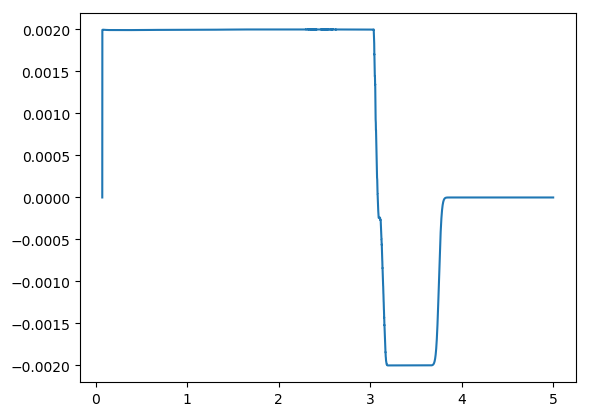

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fd94d1e19e8>

In [70]:
plot(rcell[1:10000],var.s[1:10000])

In [ ]:
 function Pistonz()

    global problem = prb(1.5e-4,0.3)
    # global problem = prb(3e-5,0.3)
     
    I = 10
    J = 100
    dx = 0.1/I
    dy = 1/J
    
    global   con1 = Const(9e7,8930,2.0,4.5e10,3940.0,1.49)
    
    Ip = (I+1)*(J+1) # Number of  points
    Ic = I*J  # number of cells
    
    global Tp = zeros(Int,Ic,4) #格点
    global Tc = zeros(Int,Ip,4) #点格
    
    #@show Tc, Ip
    global Tb = zeros(Int, I*2+J*2,3) #边界 
    
    IBL = J+1
    IBR = J+1
    IBU = I+1
    IBD = I+1
   # 点格表，格点表初始化 
    for i in 1:I 
        for j in 1:J
            ic = i+(j-1)*I
            Tp[ic,1] = i + (j-1)*(I+1)
            Tp[ic,2] = i+1 +(j-1)*(I+1)
            Tp[ic,3]=i+1+j*(I+1)
            Tp[ic,4]=i+j*(I+1) 
        end
    end
    
    for i = 1:I+1
        for j = 1:J+1
            ip = i+(j-1)*(I+1)
            Tc[ip,1] = i +(j-1)*I #(i,j)
            Tc[ip,2] = i-1+(j-1)*I #(i-1,j)
            Tc[ip,3] = i-1+(j-2)*I #(i-1,j-1)
            Tc[ip,4] = i+(j-2)*I   #(i,j-1)
            end
        end
    

# Bound 
  ib = 0
    for i = 1:I+1
        for j = 1:J+1
            if i == 1 || i== I+1 ||  j == 1 || j == J+1
                ib += 1
                ic =i+(j-1)*I
                #ic = Tc[ip]
                Tb[ib,1] = ic
                if i==1 
                    Tb[ib,2] = 4 # 1->4 
                    Tb[ib,3] = 2 # type 1:free 2:
                end   
                 if  i==I+1 
                    Tb[ib,2] = 2 #bound type 1:free 2: wall ..  Tb[:,2] y direction
                    Tb[ib,3] = 2
                end
            
                if j==1 
                    Tb[ib,2] = 1
                    Tb[ib,3] = 1
                end
                if j==J+1
                    Tb[ib,2] = 3 
                    Tb[ib,3] = 1
                end
            end
        end
    end

    #流场初始化 Init of the flow
    
    x = zeros(Float64,Ip)
    y = zeros(Float64,Ip)
    u = zeros(Float64,Ip)
    v = zeros(Float64,Ip)
    
    ρ = zeros(Float64,Ic)
    mz = zeros(Float64,Ic)
    p = zeros(Float64,Ic)
    Az= zeros(Float64,Ic)
    σ = zeros(Float64,Ic,3)
    
    for i in 1:I+1
        for j = 1:J+1
            ip =i+(j-1)*(I+1)
            x[ip] = (i-1)*dx
            y[ip] = (j-1)*dy
            u[ip] = 0
            v[ip] = 0.0
        end
    end
    
    xz = zeros(Float64,4)
    yz = zeros(Float64,4) 
    for i in 1:I
        for j in 1:J
            ic = i+(j-1)*I
            xz[1:4] = x[Tp[ic,1:4]]
            yz[1:4] = y[Tp[ic,1:4]]
            A = A_z(xz,yz)
            Az[ic] = sum(A) #[1]+A[2]+A[3]+A[4]
          #  if i>=I/2
               
                p[ic] = 1.e5
                ρ[ic] = 8930
                mz[ic] = ρ[ic] * Az[ic]
                σ[ic,1] = -p[ic]
                σ[ic,2] = -p[ic]
                σ[ic,3]= 0 
#             else
#                 mz[ic] = 1.0 * Az[ic]
#                 p[ic] = 1.0
#                 ρ[ic] = 1.0
#             end
        end
    end
    var = Var(x,y,u,v,ρ,p,σ)
    return var,mz,I,J
end

In [ ]:
var,mz,I,J=Pistonz()
#Output1
var = TimeSolve(var,mz)

In [ ]:
rcell, zcell = cell_coordinate(var.r,var.z)

In [ ]:
plot3D(var.r,var.z,var.v)
#triplot()

In [ ]:
tricontourf(var.r,var.z,var.v)

In [57]:
5/4000*2

0.0025

In [66]:
 function Wilkins()

    global problem = prb(5,0.5)
    # global problem = prb(3e-5,0.3)
     
    I =  10000
    J = 1
    dx = 5/I
    dy = 0.02/J

    I1= I+1
    J1= J+2
    global   con1 = Const(3e-3,2.785,2.0,2.76e-1,0.5328,1.338)
  #  global   con1 = Const(0.0,8930,2.0,4.5e10,3940.0,1.49)
    Ip = (I1+1)*(J1+1) # Number of  points
    Ic = I1*J1  # number of cells
    
    global Tp = zeros(Int,Ic,4) #格点
    global Tc = zeros(Int,Ip,4) #点格
    
    #@show Tc, Ip
    global Tb = zeros(Int, 2I1 + 2J1,4) #边界 
    
    ## Tb[i,1] ghost cell number
    ## Tb[i,2] bound cell number
    ## Tb[i,3] ghost cell point share with the bound 
    ## Tb[i,4] type of the boundary
    
    
    
   # 点格表，格点表初始化 
    for i in 1:I1 
        for j in 1:J1
            ic = i+(j-1)*I1
            Tp[ic,1] = i + (j-1)*(I1+1)
            Tp[ic,2] = i+1 +(j-1)*(I1+1)
            Tp[ic,3]=i+1+j*(I1+1)
            Tp[ic,4]=i+j*(I1+1) 
        end
    end
    
    for i = 1:I1+1
        for j = 1:J1+1
            ip =i+(j-1)*(I1+1)
            Tc[ip,1] = i +(j-1)*I1 #(i,j)
            Tc[ip,2] = i-1+(j-1)*I1 #(i-1,j)
            Tc[ip,3] = i-1+(j-2)*I1 #(i-1,j-1)
            Tc[ip,4] = i+(j-2)*I1   #(i,j-1)
        end
    end
    

# Bound 
  ib = 0
        for j = 1:J1
            i=1
            ib += 1
            ic =i+(j-1)*I1 
            Tb[ib,1] = ic
            Tb[ib,2] = (i+1)+(j-1)*I1
            Tb[ib,3] = 4
            Tb[ib,4] = 1
        end
    
      for i = 1:I1-1
            for j in (1,J1)
                ib += 1
                ic =i+(j-1)*I1
                
                Tb[ib,1] = ic
               
                if j==1 
                    Tb[ib,2] = i+(j+1-1)*I1
                    Tb[ib,3] = 3
                    Tb[ib,4] = 2
                end
                if j==J1
                    Tb[ib,2] = i+(j-1-1)*I1
                    Tb[ib,3] = 1
                    Tb[ib,4] = 2
                end
            end
        end
         for j = 1:J1
             i = I1
            ib += 1
            ic =i+(j-1)*I1
            Tb[ib,1] = ic
             Tb[ib,2] = (i-1)+(j-1)*I1 #bound type 1:free 2: wall ..  Tb[:,2] y direction
             Tb[ib,3] = 4
             Tb[ib,4] = 2
         end
    
    #流场初始化 Init of the flow
    
    x = zeros(Float64,Ip)
    y = zeros(Float64,Ip)
    u = zeros(Float64,Ip)
    v = zeros(Float64,Ip)
    
    ρ = zeros(Float64,Ic)
    mz = zeros(Float64,Ic)
    p = zeros(Float64,Ic)
    Az= zeros(Float64,Ic)
    s = zeros(Float64,Ic,3)
    
    for i in 1:I1+1
        for j = 1:J1+1
            ip =i+(j-1)*(I1+1)
            x[ip] = (i-1)*dx
            y[ip] = (j-2)*dy
            if x[ip]< 0.5
                u[ip] = 0.08
                v[ip] = 0.0
            else 
                u[ip] = 0.0
                v[ip] = 0.0
            end
        end
    end
    
      
    
    var = Var(x,y,u,v,ρ,p,s)
    x,y = bound_ghost_coordinate!(x,y,u,v)
  #  x,y = bound_ghost_coordinate!(x,y)
    xz = zeros(Float64,4)
    yz = zeros(Float64,4) 
    for i in 1:I1
        for j in 1:J1
            ic = i+(j-1)*(I1)
            xz[1:4] = x[Tp[ic,1:4]]
            yz[1:4] = y[Tp[ic,1:4]]
            A = A_z(xz,yz)
            Az[ic] = sum(A)
                p[ic] = 1.e-18
                ρ[ic] = 2.785
                mz[ic] = ρ[ic] * Az[ic]
                s[ic,:] .= 0       
        end
    end 
    return var,mz,I1,J1
end

Wilkins (generic function with 1 method)

In [67]:
var,mz,I,J=Wilkins()
#Output1
var = TimeSolve(var,mz)

0.050150358140985965
0.10022046426183348
0.15028859883517365
0.2000371536957475
0.2501043302731189
0.3001713896401976
0.3502384164827511
0.4003054528196913
0.45005362951197014
0.5001207515022509
0.5501879306216638
0.6002551706394073
0.6500035692387036
0.7000709259881472
0.7501383393514132
0.8002058076643883
0.8502733273351585
0.9000219927698793
0.9500896042078891
1.0001572592135701
1.0502249534757573
1.1002926824958503
1.150041544457599
1.2001093396921088
1.250177164407123
1.3002450175862386
1.3503128946611582
1.4000618934822846
1.4501298162221683
1.5001977613154793
1.5502657238012931
1.600014801278871
1.6500827984411344
1.700150811536454
1.7502188398749916
1.8002868803394774
1.8500360306328956
1.900104096244782
1.9501721737355624
2.0002402620907986
2.0503083592712628
2.100057560917812
2.150125676455843
2.200193799691193
2.2502619310970178
2.3000111644216035
2.3500793095061066
2.400147461063908
2.450215618591373
2.5002837812088137
2.550033043471821
2.6001012164065935
2.6501693936528787

Var([0.0700813, 0.0705813, 0.0710808, 0.0715796, 0.0720784, 0.0725773, 0.0730762, 0.0735752, 0.0740741, 0.0745731  …  4.996, 4.9965, 4.997, 4.9975, 4.998, 4.9985, 4.999, 4.9995, 5.0, 5.0005], [-0.02, -0.02, -0.02, -0.02, -0.02, -0.02, -0.02, -0.02, -0.02, -0.02  …  0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04], [0.000699843, 0.000699843, 0.000699843, 0.000699844, 0.000699844, 0.000699844, 0.000699845, 0.000699846, 0.000699846, 0.000699847  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.24284e-21, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [2.785, 2.78824, 2.79169, 2.79145, 2.79123, 2.79103, 2.79086, 2.79072, 2.79061, 2.79052  …  2.785, 2.785, 2.785, 2.785, 2.785, 2.785, 2.785, 2.785, 2.785, 2.785], [1.9988e-7, 0.000944756, 0.00199452, 0.00199424, 0.00199416, 0.00199411, 0.00199307, 0.00199319, 0.00199502, 0.00199614  …  1.0e-18, 1.0e-18, 1.0e-18, 1.0e-18, 1.0e-18, 1.0e-18, 1.0e-18, 1.0e-18, 1.0e-18, 1.0

## 单位变换

$$ 1kg/m^3 = 10^{-3} g/cm^3$$
$$1m/s = 10^{-4} cm/\mu s$$
$$ 1Pa = 1N/m^2 = 1kg/(m\cdot s^2) = (1000g)/(100cm \cdot 10^{12} \mu s^2) = 10^{-11} g/(cm \cdot s^2)$$ 

In [158]:
 function Collapse()

    global problem = prb(1.3e2,0.3)
  #  global problem = prb(50,0.3)
    # global problem = prb(5e-5,0.3)
    
    I = 40
    J = 32
    dr = 2.0/J
    dθ = 90/I
    
    I1 = I +2
    J1 = J
    
    global   con1 = Const(3.3e-3,1.845,2.0,1.519,1.287,1.124)
    
    Ip = (I1+1)*(J1+1) # Number of  points
    Ic = I1*J1  # number of cells
    
     Ip = (I1+1)*(J1+1) # Number of  points
    Ic = I1*J1  # number of cells
    
    global Tp = zeros(Int,Ic,4) #格点
    global Tc = zeros(Int,Ip,4) #点格
    
    #@show Tc, Ip
    global Tb = zeros(Int, 2I1 + 2J1,4) #边界 
    
    ## Tb[i,1] ghost cell number
    ## Tb[i,2] bound cell number
    ## Tb[i,3] ghost cell point share with the bound 
    ## Tb[i,4] type of the boundary
    
    
    
   # 点格表，格点表初始化 
    for i in 1:I1 
        for j in 1:J1
            ic = i+(j-1)*I1
            Tp[ic,1] = i + (j-1)*(I1+1)
            Tp[ic,2] = i+1 +(j-1)*(I1+1)
            Tp[ic,3]=i+1+j*(I1+1)
            Tp[ic,4]=i+j*(I1+1) 
        end
    end
    
    for i = 1:I1+1
        for j = 1:J1+1
            ip =i+(j-1)*(I1+1)
            Tc[ip,1] = i +(j-1)*I1 #(i,j)
            Tc[ip,2] = i-1+(j-1)*I1 #(i-1,j)
            Tc[ip,3] = i-1+(j-2)*I1 #(i-1,j-1)
            Tc[ip,4] = i+(j-2)*I1   #(i,j-1)
        end
    end
    

# Bound 
  ib = 0
        for j = 1:J1
            i=1
            ib += 1
            ic =i+(j-1)*I1 
            Tb[ib,1] = ic
            Tb[ib,2] = (i+1)+(j-1)*I1
            Tb[ib,3] = 2
            Tb[ib,4] = 2
        end
         for j = 1:J1
             i = I1
            ib += 1
            ic =i+(j-1)*I1
            Tb[ib,1] = ic
             Tb[ib,2] = (i-1)+(j-1)*I1 #bound type 1:free 2: wall ..  Tb[:,2] y direction
             Tb[ib,3] = 4
             Tb[ib,4] = 2
         end
      for i = 1:I1
            for j in (1,J1)
                ib += 1
                ic =i+(j-1)*I1
                
                Tb[ib,1] = ic
               
                if j==1 
                    Tb[ib,2] = i+(j+1-1)*I1
                    Tb[ib,3] = 1
                    Tb[ib,4] = 1
                end
                if j==J1
                    Tb[ib,2] = i+(j-1-1)*I1
                    Tb[ib,3] = 3
                    Tb[ib,4] = 1
                end
            end
        end
        
    #流场初始化 Init of the flow
    
    x = zeros(Float64,Ip)
    y = zeros(Float64,Ip)
    u = zeros(Float64,Ip)
    v = zeros(Float64,Ip)
    
    ρ = zeros(Float64,Ic)
    mz = zeros(Float64,Ic)
    p = zeros(Float64,Ic)
    Az= zeros(Float64,Ic)
    s = zeros(Float64,Ic,3)
    
    for i in 1:I1+1
        for j = 1:J1+1
            ip =i+(j-1)*(I1+1)
            r₁ = (j-1)*dr+8
            θ = 90-(i-2)*dθ
            v₀ = 4.171e-2
            x[ip] = cosd(θ)*r₁
            y[ip] = sind(θ)*r₁
            u[ip] = -v₀*8/r₁ *cosd(θ)
            v[ip] = -v₀*8/r₁ *sind(θ)
        end
    end
      
    
    var = Var(x,y,u,v,ρ,p,s)
    x,y,u,v = bound_ghost_coordinate!(x,y,u,v)
    xz = zeros(Float64,4)
    yz = zeros(Float64,4) 
    for i in 1:I1
        for j in 1:J1
            ic = i+(j-1)*(I1)
            xz[1:4] = x[Tp[ic,1:4]]
            yz[1:4] = y[Tp[ic,1:4]]
            A = A_z(xz,yz)
            Az[ic] = sum(A)
                p[ic] = 1.e-5
                ρ[ic] = 1.845
                mz[ic] = ρ[ic] * Az[ic]
                s[ic,:] .= 0       
        end
    end 
    return var,mz,I1,J1
end

Collapse (generic function with 1 method)

In [205]:
var,mz,I,J = Collapse()
var = TimeSolve(var,mz)

1.3039213263803646
2.604500809690488
3.901861922878127
5.205127897109418
6.503384992875783
7.806864222873404
9.105261006656146
10.409076912289041
11.70718409535844
13.011145905828513
14.308864663231898
15.600828565769463
16.90983404411175
18.20095487539812
19.509463428966693
20.811454092180767
22.10716071952466
23.40816665911913
24.70248420661775
26.00220279963952
27.30707842268777
28.605140694620385
29.90841314194967
31.204535558010267
32.50582712223696
33.81216230307348
35.111155581235955
36.40274054190073
37.71163206795117
39.00042297867973
40.306583286372366
41.60490805063909
42.9079955632206
44.203086264825444
45.502756506796615
46.80704965552695
48.10305442386652
49.40350475391511
50.7084219972956
52.004759263767426
53.305393317055135
54.61032704611526
55.90638668346627
57.206580480038035
58.51089778317693
59.80604298937367
61.10514766355113
62.408191738667824
63.70176160426375
65.01250022359649
66.3001981485837
67.60498058856876
68.9134185051003
70.21193438872108
71.500360516995

Var([-0.196139, 0.0, 0.196139, 0.391976, 0.587208, 0.781534, 0.974656, 1.16627, 1.3561, 1.54382  …  7.42598, 7.51498, 7.5924, 7.65811, 7.71201, 7.75402, 7.78407, 7.80212, 7.80814, 7.80212], [4.99207, 4.99592, 4.99207, 4.98052, 4.96129, 4.93441, 4.89993, 4.85788, 4.80835, 4.7514  …  2.41285, 2.11944, 1.82277, 1.52329, 1.22146, 0.917748, 0.61262, 0.306546, 0.0, -0.306546], [1.26386e-5, -0.0, 1.26386e-5, 2.52576e-5, 3.78377e-5, 5.03595e-5, 6.28037e-5, 7.51509e-5, 8.73824e-5, 9.9479e-5  …  0.000224848, 0.000227543, 0.000229887, 0.000231877, 0.000233509, 0.000234781, 0.000235691, 0.000236237, 0.000236419, 0.000236237], [0.000321673, 0.000321921, 0.000321673, 0.000320929, 0.00031969, 0.000317958, 0.000315735, 0.000313026, 0.000309834, 0.000306165  …  7.30576e-5, 6.41738e-5, 5.5191e-5, 4.61231e-5, 3.69841e-5, 2.77881e-5, 1.85493e-5, 9.28178e-6, 0.0, 9.28178e-6], [1.84398, 1.84398, 1.84398, 1.84398, 1.84398, 1.84398, 1.84398, 1.84398, 1.84398, 1.84398  …  1.84499, 1.84499, 1.84499, 1.84499, 1.

In [150]:
var,mz,I,J = Collapse()
var = TimeSolve(var,mz)
using DelimitedFiles
(I,J,var,mz)

1.3039213208034708
(kinetic / kinetic_init, (energy + kinetic) / (kinetic_init + energy_init)) = (0.98496558001273, 0.9999999224068559)
2.6045007914611347
(kinetic / kinetic_init, (energy + kinetic) / (kinetic_init + energy_init)) = (0.9690597567637653, 0.9999997520604826)


InterruptException: InterruptException:

In [151]:
using DelimitedFiles
Output_point(I,J,var,mz)

UndefVarError: UndefVarError: I1 not defined

In [207]:
tmp =0.0
for i in 1:41
   tmp += √(var.r[i]^2 + var.z[i]^2)
end
@show tmp/41

tmp / 41 = 4.995921896119672


4.995921896119672

In [208]:
tmax =0.0
for i in 1:41
    tmp2 = √(var.r[i]^2 + var.z[i]^2)
    if abs(tmp2 - tmp/41) >tmax
        tmax = abs(tmp2-tmp/41)
    end
end
@show tmax

tmax = 3.949729432406457e-12


3.949729432406457e-12

In [ ]:
 rcell = zeros(Float64,4)
    zcell = zeros(Float64,4)
    ucell = zeros(Float64,4)
    vcell = zeros(Float64,4)

Ic, = size(Tp) 
for i in 1:Ic
        for j =1:4
            rcell[j] = var.r[Tp[i,j]]
            zcell[j] = var.z[Tp[i,j]]
            ucell[j] = var.u[Tp[i,j]]
            vcell[j] = var.v[Tp[i,j]]
        end
        Az = sum(A_z(rcell,zcell))
@show Az
end

In [210]:
 function Impact()

    global problem = prb(6000,0.3)
    # global problem = prb(5e-5,0.3)
    
    I = 200
    J = 40
    dx = 500/I
    dy = 100/J
    
    global   con1 = Const(3e-3,2.785,2.0,2.7e-1,0.5328,1.338)
    
    I1 = I +1
    J1 = J
    
    Ip = (I1+1)*(J1+1) # Number of  points
    Ic = I1*J1  # number of cells
    
    global Tp = zeros(Int,Ic,4) #格点
    global Tc = zeros(Int,Ip,4) #点格
    
    #@show Tc, Ip
    global Tb = zeros(Int, 2I1 + 2J1,4) #边界 
    
    ## Tb[i,1] ghost cell number
    ## Tb[i,2] bound cell number
    ## Tb[i,3] ghost cell point share with the bound 
    ## Tb[i,4] type of the boundary
    
    
    
   # 点格表，格点表初始化 
    for i in 1:I1 
        for j in 1:J1
            ic = i+(j-1)*I1
            Tp[ic,1] = i + (j-1)*(I1+1)
            Tp[ic,2] = i+1 +(j-1)*(I1+1)
            Tp[ic,3]=i+1+j*(I1+1)
            Tp[ic,4]=i+j*(I1+1) 
        end
    end
    
    for i = 1:I1+1
        for j = 1:J1+1
            ip =i+(j-1)*(I1+1)
            Tc[ip,1] = i +(j-1)*I1 #(i,j)
            Tc[ip,2] = i-1+(j-1)*I1 #(i-1,j)
            Tc[ip,3] = i-1+(j-2)*I1 #(i-1,j-1)
            Tc[ip,4] = i+(j-2)*I1   #(i,j-1)
        end
    end
    
# Bound 
  ib = 0
        for j = 1:J1
            i=1
            ib += 1
            ic =i+(j-1)*I1 
            Tb[ib,1] = ic
            Tb[ib,2] = (i+1)+(j-1)*I1
            Tb[ib,3] = 2
            Tb[ib,4] = 2
        end
    
         for j = 1:J1
             i = I1
            ib += 1
            ic =i+(j-1)*I1
            Tb[ib,1] = ic
             Tb[ib,2] = (i-1)+(j-1)*I1 #bound type 1:free 2: wall ..  Tb[:,2] y direction
             Tb[ib,3] = 2
             Tb[ib,4] = 1
         end
      for i = 1:I1
            for j in (1,J1)
                ib += 1
                ic =i+(j-1)*I1
                
                Tb[ib,1] = ic
               
                if j==1 
                    Tb[ib,2] = i+(j+1-1)*I1
                    Tb[ib,3] = 1
                    Tb[ib,4] = 1
                end
                if j==J1
                    Tb[ib,2] = i+(j-1-1)*I1
                    Tb[ib,3] = 3
                    Tb[ib,4] = 1
                end
            end
        end
        
    #流场初始化 Init of the flow
    
    x = zeros(Float64,Ip)
    y = zeros(Float64,Ip)
    u = zeros(Float64,Ip)
    v = zeros(Float64,Ip)
    
    ρ = zeros(Float64,Ic)
    mz = zeros(Float64,Ic)
    p = zeros(Float64,Ic)
    Az= zeros(Float64,Ic)
    s = zeros(Float64,Ic,3)
    
    for i in 1:I1+1
        for j = 1:J1+1
            ip =i+(j-1)*(I1+1)
            x[ip] = (i-2)*dx
            y[ip] = (j-1)*dy
            u[ip] = -1.50e-2
            v[ip] = 0.0
        end
    end
    
    var = Var(x,y,u,v,ρ,p,s)
    x,y,u,v = bound_ghost_coordinate!(x,y,u,v)
    xz = zeros(Float64,4)
    yz = zeros(Float64,4) 
    for i in 1:I1
        for j in 1:J1
            ic = i+(j-1)*(I1)
            xz[1:4] = x[Tp[ic,1:4]]
            yz[1:4] = y[Tp[ic,1:4]]
            A = A_z(xz,yz)
            Az[ic] = sum(A)
                 p[ic] = 1e-10
                ρ[ic] = 2.785
                mz[ic] = ρ[ic] * Az[ic]
                s[ic,:] .= 0
        end
    end 
 return var,mz,I1,J1
end

Impact (generic function with 1 method)

In [211]:
var,mz,I,J = Impact()
var = TimeSolve(var,mz)

60.708028495719624
120.82451495742694
180.09696352454657
240.79276608475982
300.4233529358316
360.0517404486461
420.5580728903971
480.5424533442195
540.408984886226
600.2993988816921
660.3446767628301
720.4801665938892
780.5848064816123
840.4778432867537
900.2597550718571
960.0750905825424
1020.6021853245408
1080.4474796946042
1140.2997116868792
1200.808120125757
1260.2102502113203
1320.2017136499867
1380.7646253746823
1440.373285683224
1500.4948856506408
1560.2108667184318
1620.2291917198836
1680.4390472172145
1740.163206242754
1800.1584219122728
1860.318358768791
1920.563048779007
1980.1926572525717
2040.415438590946
2100.6038775266156
2160.0743013764136
2220.0932724809945
2280.2355841135864
2340.3569706454246
2400.1653934736364
2460.2360415548737
2520.4454160433243
2580.253142740205
2640.2400942922773
2700.4327958549384
2760.018055118926
2820.3164621568076
2880.395952172861
2940.2391273474223
3000.2164673707844
3060.229789498408
3120.2354089879964
3180.069059001976
3240.322408436828

Var([-2.4305, 0.0, 2.4305, 4.73989, 7.0004, 9.25766, 11.5133, 13.7615, 16.0139, 18.27  …  438.201, 440.701, 443.201, 445.7, 448.2, 450.7, 453.2, 455.7, 458.2, 460.7], [-37.5473, -37.8323, -37.5473, -36.9725, -36.3902, -35.8024, -35.2135, -34.6315, -34.0506, -33.4621  …  99.9997, 99.9997, 99.9998, 99.9999, 99.9999, 99.9999, 99.9998, 99.9995, 99.9992, 99.9988], [-8.6835e-6, -0.0, -8.6835e-6, -1.50168e-5, -1.7633e-5, -1.6492e-5, -1.29013e-5, -5.30202e-6, 8.32736e-6, 2.85233e-5  …  0.00225424, 0.00226842, 0.0022848, 0.00230264, 0.00232038, 0.0023366, 0.00235135, 0.00236268, 0.00236928, 0.0023716], [0.000244483, 0.000249211, 0.000244483, 0.000232108, 0.000215131, 0.000196122, 0.000174465, 0.000151029, 0.000127405, 0.000106968  …  5.65458e-5, 6.56965e-5, 6.96395e-5, 6.74753e-5, 5.80532e-5, 4.35544e-5, 2.43641e-5, 1.24646e-6, -2.27492e-5, -4.75032e-5], [2.77738, 2.77738, 2.77747, 2.77717, 2.77702, 2.77692, 2.77688, 2.77684, 2.77678, 2.77667  …  2.78518, 2.78517, 2.78516, 2.78513, 2.7851, 2.78

In [212]:
using DelimitedFiles
Output_point(I,J,var,mz)

In [75]:
var.v

572-element Array{Float64,1}:
 -1.4633934829493118e-15
 -1.0345411112180169e-15
 -1.4633934829493118e-15
 -8.402729866514592e-16 
 -1.819951438562635e-15 
 -1.6524145564511796e-15
 -1.0847136930431504e-15
 -1.8534701447445326e-15
 -1.2730300809946046e-15
 -1.5045826999307195e-15
 -1.852448122257305e-15 
  1.590841104610437e-16 
  1.277873532391558e-16 
  ⋮                     
  1.4916201984353308e-15
  4.785147484741018e-15 
 -1.2136095546182232e-14
  8.73102430927251e-15  
 -7.300128622214157e-15 
 -3.156780179231275e-15 
  1.184636289854388e-14 
 -1.1481352315820308e-15
 -4.29977164197353e-15  
 -6.678509989591749e-14 
 -4.0995749000291245e-14
 -3.595126613051837e-18 